# Gabor Filters and Filter Banks

Implement gabor filter analysis and classification. Delivering in article format and as a slide presentation. 

Sources:
1. [Gabor Filters, Wikipedia](https://en.wikipedia.org/wiki/Gabor_filter)
2. [https://www.sciencedirect.com/topics/engineering/gabor-filter](https://www.sciencedirect.com/topics/engineering/gabor-filter)
3. [https://www.baeldung.com/cs/ml-gabor-filters](https://www.baeldung.com/cs/ml-gabor-filters)
4. [58 - What are Gabor filters?](https://www.youtube.com/watch?v=QEz4bG9P3Qs)
5. [https://inc.ucsd.edu/mplab/75/media//gabor.pdf](https://inc.ucsd.edu/mplab/75/media//gabor.pdf)
6. [https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97](https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97)
7. [Gabor filter banks for texture classification, scikit-image](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_gabor.html)
8. [Gabor Filters, The University of Edinburgh](https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/TRAPP1/filter.html)
9. [Tutorial 74 - What are Gabor filters and how to use them to generate features for machine learning?](https://www.youtube.com/watch?v=yn1NUwaxhZg)

In [515]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import imageio.v3 as iio

In [516]:
def rerange(img : np.ndarray, 
            min = 0.0, 
            max = 1.0):
  """Function that converts an image to the given desired range.
  
  Parameters
  ----------

  img : np.ndarray
    Image to be normalized.
  min : float
    Bottom value of the new range for conversion.
  max : float
    Top value of the new range for conversion."""
  return ((img - np.min(img))/(np.max(img) - np.min(img)))*(max - min) + min

def to_image(img : np.ndarray):
  """Converts an image to the 8-bit unsigned integer range

  Parameters
  ----------

  img : np.ndarray
    Image to be converted."""
  
  return rerange(img, 0.0, 255.0).astype(np.uint8)

def convert_to_grayscale(img : np.ndarray):
  """Function that converts an image to grayscale with standard color weights.

  Parameters
  ----------

  img : np.ndarray
    Image to be converted."""

  return to_image(0.299*img[:, :, 0] + 0.587*img[:, :, 1] + 0.114*img[:, :, 2])

def gaussian_filter(shape, 
                    angle, 
                    sigma, 
                    gamma):
    x_l, y_l = shape

    gamma = gamma*x_l/y_l

    M = np.matrix([[np.cos(angle), -np.sin(angle)], 
                   [np.sin(angle),  np.cos(angle)]])
    
    x_ = np.linspace(-x_l//2, x_l//2, x_l)
    y_ = np.linspace(-y_l//2, y_l//2, y_l)

    x, y = np.meshgrid(x_, y_)

    R = np.asarray(M*np.matrix([np.ravel(x), np.ravel(y)]))

    x_r = R[0].reshape(x.shape)
    y_r = R[1].reshape(y.shape)
    
    g = np.exp(-0.5*(x_r**2 + (gamma*y_r)**2)/sigma**2)
    
    return rerange(g)

def sinusoidal_filter(shape, 
                      angle,
                      lamb, 
                      phi):
   
    x_l, y_l = shape

    gamma = x_l/y_l

    M = np.matrix([[np.cos(angle), -np.sin(angle)], 
                   [np.sin(angle),  np.cos(angle)]])
    
    x_ = np.linspace(-x_l//2, x_l//2, x_l)
    y_ = np.linspace(-y_l//2, y_l//2, y_l)

    x, y = np.meshgrid(x_, y_, )

    R = np.asarray(M*np.matrix([np.ravel(x), np.ravel(y)]))

    x_r = R[0].reshape(x.shape)
    y_r = R[1].reshape(y.shape)

    s = np.exp( -1j*((2*np.pi/lamb)*( x_r) + phi))

    return rerange(s)

def gabor_filter(shape, 
                 angle, 
                 sigma, 
                 gamma,
                 lamb, 
                 phi):
   
   return rerange(sinusoidal_filter(shape, angle, lamb, phi)*gaussian_filter(shape, angle, sigma, gamma)) 

def histogram(img : np.ndarray):
    """Produces a histogram of the image. 
    Returns a tuple with the unique values and its counts.
    
    Parameters
    ----------
     
    img : np.ndarray (N, M)
        Grayscale image to be processed."""
    
    val, counts = np.unique(img, return_counts=True)

    rang = np.arange(0, 256, 1).astype(np.int64)
    hist = np.zeros_like(rang).astype(np.int64)
    hist[val] += counts
    
    return rang, hist

def thresholding(img : np.ndarray, threshold : float = 0.5):
  """Limiarizes the image given a threshold. If the image is not on grayscale format,
  it will be converted to and then limiarized.
  
  Parameters
  ----------
  
  img : np.ndarray
    Image to be limiarized.
  threshold : float inside the range (0.0, 1.0]
    Threshold to limiarize the image."""
  assert 0.0 < threshold < 1.0, 'threshold out of range of (0.0, 1.0].'
  new_img = convert_to_grayscale(img) if len(img.shape) > 2 else np.copy(img)

  new_img = rerange(new_img)

  new_img[img < threshold] = 0.0
  new_img[img >= threshold] = 1.0

  return new_img

def otsu_thresholding(img):
    """Applies an otsu thresholding to an image.
     
    Parameters
    ----------
    
    img : np.ndarray
        Image to be thresholded."""
    val, counts = histogram(img)

    P = img.shape[0]*img.shape[1]

    p = counts/P

    cumsum = lambda p, i, L : np.sum(p[i:L])

    T = np.arange(0, p.shape[0], 1, dtype=int)

    w0 = np.array([cumsum(p, 0, T[i]) for i in range(T.shape[0])])
    w1 = np.array([cumsum(p, T[i], p.shape[0]) for i in range(T.shape[0])])

    mi0 = np.zeros_like(w0)
    mi1 = np.zeros_like(w1)

    mi0[w0 != 0] = np.array([np.sum(i*p[0 : T[i]]) for i in range(T.shape[0])])[w0 != 0]
    mi1[w1 != 0] = np.array([np.sum(i*p[T[i]: p.shape[0]]) for i in range(T.shape[0])])[w1 != 0]

    mi0[w0 != 0] = mi0[w0 != 0]/w0[w0 != 0]
    mi1[w1 != 0] = mi1[w1 != 0]/w1[w1 != 0]

    sigma_b = w0*w1*(mi0 - mi1)**2

    threshold = T[np.where(sigma_b == np.nanmax(sigma_b))[0][0]]/256.0

    return to_image(thresholding(rerange(img), threshold))

(-0.5, 329.5, 329.5, -0.5)

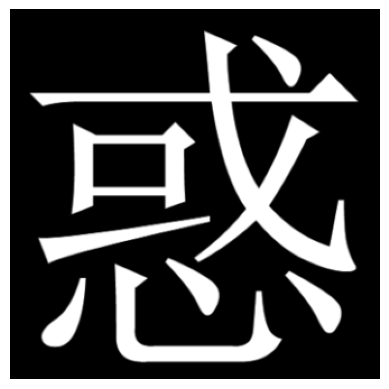

In [517]:
img = iio.imread("samples/chinese.png")
img = convert_to_grayscale(img)[:330, :330]

# img = iio.imread("samples/cameraman.tif")

plt.imshow(img, cmap = "gray")
plt.axis("off")

In [518]:
lamb = 30
phi = 0.0
sigma = 5.0
angle = np.pi/2.0
gamma = 0.5
shape = img.shape

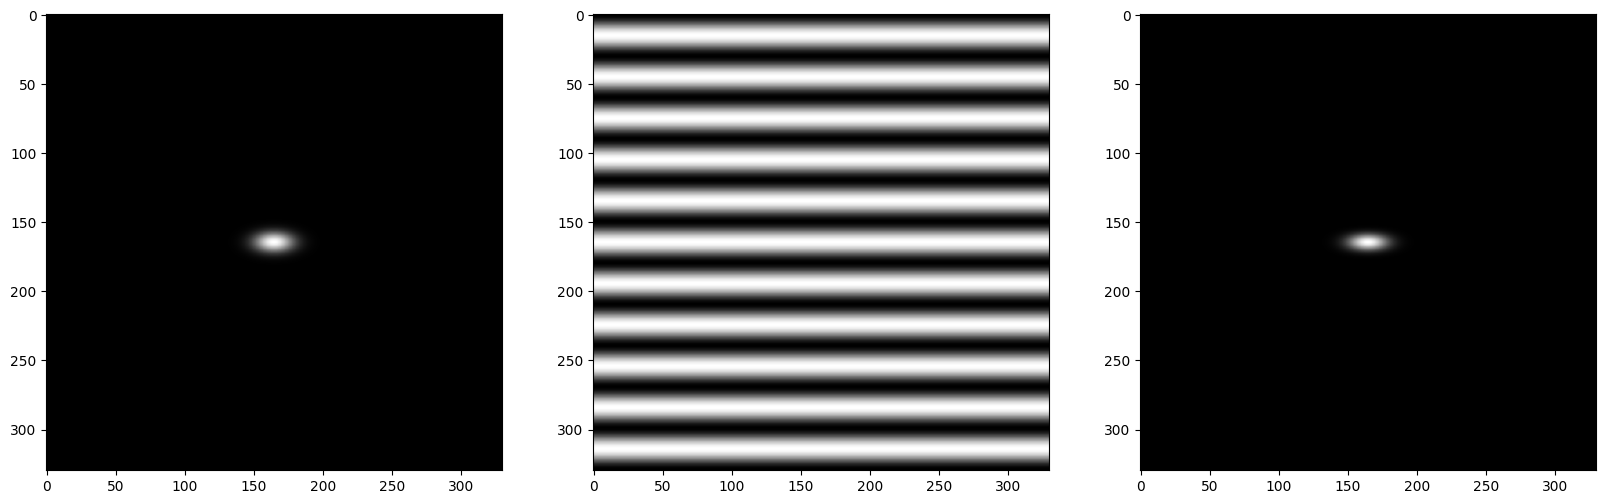

In [519]:
g = gaussian_filter(shape, angle, sigma, gamma)
s = sinusoidal_filter(shape, angle, lamb, phi)

gab = gabor_filter(shape, angle, sigma, gamma, lamb, phi)

plt.figure(figsize = (20, 20))

plt.subplot(131)
plt.imshow(g, cmap = "gray")

plt.subplot(132)
plt.imshow(s.real, cmap = "gray")

plt.subplot(133)
plt.imshow(gab.real, cmap = "gray")

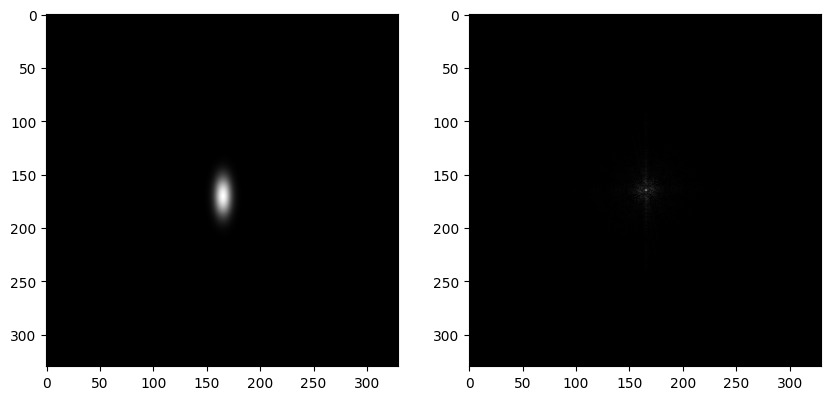

In [520]:
gabor_fft = fft2(gab)
gabor_fft = fftshift(gabor_fft)

img_fft = fft2(img)
img_fft = fftshift(img_fft)


plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(np.abs(gabor_fft), cmap = "gray")

plt.subplot(122)
plt.imshow(np.abs(img_fft), cmap = "gray")


-13386.621476852873 10043.451564184223


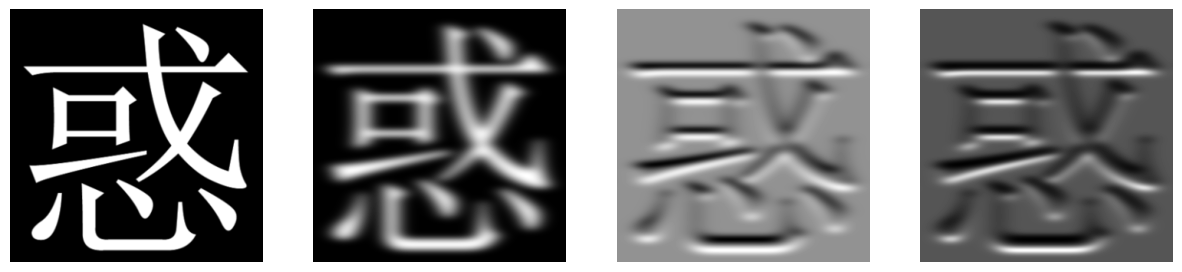

In [521]:
new_img_fft = gabor_fft*img_fft

new_img_fft = ifftshift(new_img_fft)

new_img = ifft2(new_img_fft)

new_img = ifftshift(new_img)

plt.figure(figsize = (15,15))
plt.subplot(141)
plt.imshow(img, cmap = "gray")
plt.axis("off")

plt.subplot(142)
plt.imshow(new_img.real, cmap = "gray")
plt.axis("off")

plt.subplot(143)
plt.imshow(new_img.imag, cmap = "gray")
plt.axis("off")

plt.subplot(144)
plt.imshow(np.exp(rerange(new_img.imag))**2, cmap = "gray")
plt.axis("off")
